# Introduction to Zettapark for Python

A simple demo of how Zetta for Python can be used.

You need to load the Campaign spend data, see 00_load_demo_data notebook, and have config.json file with your credetials.

In [1]:
# Zettapark
import clickzetta.zettapark as C
from clickzetta.zettapark import Session
import clickzetta.zettapark.types as T
import clickzetta.zettapark.functions as F
from clickzetta.zettapark import Window

# Print the version of Zettapark we are using
print(f"Using Zettapark: {C.__version__}")

Using Zettapark: 0.1.3


In [2]:
#!pip install sqlparse

In [3]:
import json

# Make sure we do not get line breaks when doing show on wide dataframes
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

import seaborn as sns
import matplotlib.pyplot as plt
import sqlparse

Create a connection to Lakehouse.

This example is using a JSON file with the following structure
```
{
  "username": "Please enter your username",
  "password": "Please enter your password",
  "service": "Please enter your service address, e.g. api.clickzetta.com",
  "instance": "Please enter your instance ID",
  "workspace": "Please enter your workspace, e.g. gharchive",
  "schema": "Please enter your schema, e.g. public",
  "vcluster": "Please enter your virtual cluster, e.g. default_ap",
  "sdk_job_timeout": 10,
  "hints": {
    "sdk.job.timeout": 3,
    "query_tag": "Introduction to Zettapark for Python"
  }
}


```

In [4]:
import json

# read connection parameters
with open('config.json', 'r') as config_file:
    config = json.load(config_file)

print("Connecting to Lakehouse.....\n")

# create session
session = Session.builder.configs(config).create()

print("Connected and context as below...\n")

# print(session.sql("SELECT current_instance_id(), current_workspace(),current_workspace_id(), current_schema(), current_user(),current_user_id(), current_vcluster()").collect())

Connecting to Lakehouse.....

Connected and context as below...



In [5]:
session.sql_simplifier_enabled = True

In [6]:
connect_schema = session.get_current_schema()

print(f"Current schema: {connect_schema}")


Current schema: CREDIT_SCORING_SCH


The parameters provided for creating a session sets the context ie database, schema, viritual warehouse and role. This can be changed using the **use_** function on the session object

Chaning the active schema to config["schema"]

In [11]:
session.use_schema(config["schema"])
session.get_current_schema()

'CREDIT_SCORING_SCH'

We can write SQL using **sql** function on the session object, if we want the SQL to execute on Sowflake we need to use a action method like **show()** or **collect()**

In [12]:
session.sql("SHOW VCLUSTERS").show()

+-------------------+-------------+-------------+---------------+---------+----------------+--------------------+------------+------------+-----------------+-----------------+---------------------+--------------+----------------+----------------------+-----------------------+------------+-----------+-------------+
|               name|vcluster_size|vcluster_type|max_concurrency|    state|         creator|         create_time|min_replicas|max_replicas|min_vcluster_size|max_vcluster_size|current_vcluster_size|preload_tables|current_replicas|auto_suspend_in_second|auto_scale_in_in_second|running_jobs|queued_jobs|error_message|
+-------------------+-------------+-------------+---------------+---------+----------------+--------------------+------------+------------+-----------------+-----------------+---------------------+--------------+----------------+----------------------+-----------------------+------------+-----------+-------------+
|  CREDIT_SCORING_VC|            2|      GENERAL|   

In [13]:
df_campaign_spend = session.table("CAMPAIGN_SPEND")

In [14]:
df_campaign_spend.queries

{'queries': ['SELECT  *  FROM CAMPAIGN_SPEND'], 'post_actions': []}

In [15]:
df_campaign_spend.show()

+--------------------+-------------+----------+------------+----------+----------+
|            campaign|      channel|      date|total_clicks|total_cost|ads_served|
+--------------------+-------------+----------+------------+----------+----------+
|       winter_sports|        video|2012-06-03|         213|      1762|       426|
|sports_across_cul...|        video|2012-06-02|          87|       678|       157|
|  building_community|search_engine|2012-06-03|          66|       471|       134|
|        world_series| social_media|2017-12-28|          72|       591|       149|
|       winter_sports|        email|2018-02-09|         252|      1841|       473|
|        spring_break|        video|2017-11-14|         162|      1155|       304|
|          nba_finals|        email|2017-11-22|          68|       480|       134|
|       winter_sports| social_media|2018-03-10|         227|      1797|       454|
|        spring_break|search_engine|2017-08-30|         150|      1226|       302|
|   

Aggregating a DataFrame

In [16]:
df_spend_yearly = df_campaign_spend.group_by(F.year("DATE"), "CHANNEL").sum("TOTAL_COST")

Using the **sqlparse** libary to generate nicer print of the dataframe sql

In [17]:
print(sqlparse.format(df_spend_yearly.queries['queries'][0], reindent=True))

SELECT year(`date`) AS ```year``(``date``)`,
       `channel`,
       sum(`total_cost`) AS ```sum``(total_cost)`
FROM
  (SELECT *
   FROM CAMPAIGN_SPEND)
GROUP BY year(`date`),
         `channel`


In [18]:
df_spend_yearly.show()

+--------------+-------------+-----------------+
|`year`(`date`)|      channel|`sum`(total_cost)|
+--------------+-------------+-----------------+
|          2019|search_engine|          6130718|
|          2020| social_media|          6140218|
|          2020|        video|          6141113|
|          2020|search_engine|          6164277|
|          2019|        email|          6133148|
|          2019| social_media|          6142536|
|          2020|        email|          6143928|
|          2019|        video|          6132841|
|          2012|search_engine|          4117683|
|          2012|        video|          4122125|
+--------------+-------------+-----------------+



If we would like to plot the data we need to use a third-party library like seaborn that supports Pandas Dataframe as input.
A Pandas dataframe can be created with Zettapark using the **to_pandas** function.

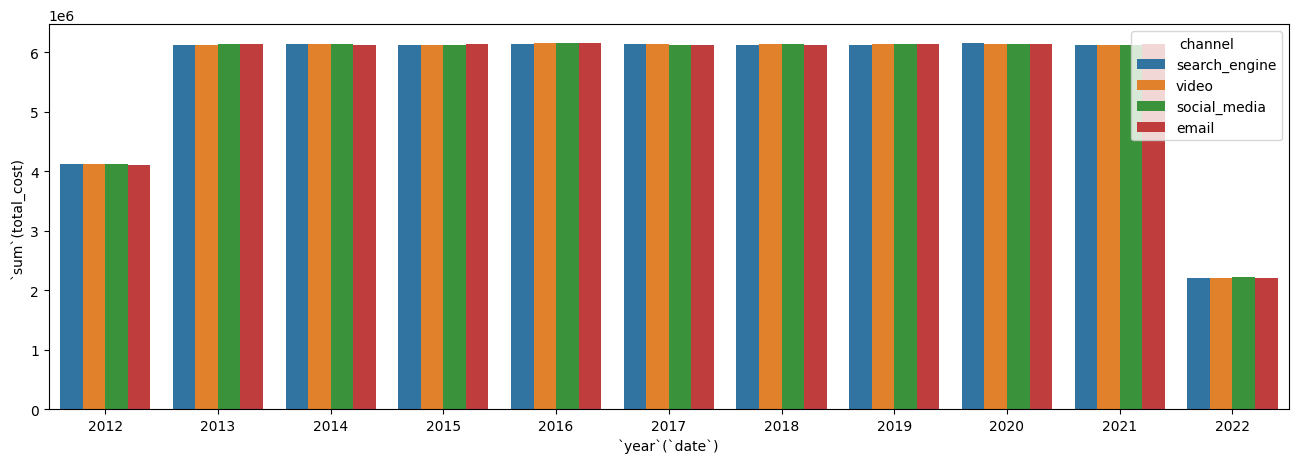

In [19]:
pd_data = df_spend_yearly.to_pandas()
fig, ax = plt.subplots(figsize=(16, 5))
g = sns.barplot(
    data=pd_data,
    x="`year`(`date`)", y="`sum`(total_cost)", hue="channel", ax=ax
)
plt.show()

Of course can multiple agregation be done at the same time

In [20]:
df_campaign_spend.group_by(F.year("DATE"), "CHANNEL").agg([F.sum("TOTAL_COST").as_("TOTAL_COST"),
                                                           F.avg("TOTAL_COST").as_("AVG_COST")]).show()

+--------------+-------------+----------+--------+
|`year`(`date`)|      channel|total_cost|avg_cost|
+--------------+-------------+----------+--------+
|          2019|search_engine|   6130718|839.8244|
|          2020| social_media|   6140218|838.8276|
|          2020|        video|   6141113|838.9499|
|          2020|search_engine|   6164277|842.1143|
|          2019|        email|   6133148|840.1573|
|          2019| social_media|   6142536|841.4433|
|          2020|        email|   6143928|839.3344|
|          2019|        video|   6132841|840.1152|
|          2012|search_engine|   4117683|840.3435|
|          2012|        video|   4122125|841.2500|
+--------------+-------------+----------+--------+



In [21]:
df_campaign_spend.group_by(F.year("DATE"), "CHANNEL").agg([F.sum("TOTAL_COST").as_("TOTAL_COST"), 
                                                           F.avg("TOTAL_COST").as_("AVG_COST")])\
                    .filter(F.col("AVG_COST") > 840.7).show()


+--------------+-------------+----------+--------+
|`year`(`date`)|      channel|total_cost|avg_cost|
+--------------+-------------+----------+--------+
|          2020|search_engine|   6164277|842.1143|
|          2019| social_media|   6142536|841.4433|
|          2012|        video|   4122125|841.2500|
|          2017|        video|   6137428|840.7436|
|          2016| social_media|   6154412|840.7667|
|          2013|        email|   6141913|841.3579|
+--------------+-------------+----------+--------+



To summarise a column for the whole table

In [22]:
df_campaign_spend.select(F.sum("TOTAL_COST").as_("TOTAL_COST")).show()

+----------+
|total_cost|
+----------+
| 246187482|
+----------+



We can by using Window functions calculate things like running sum

In [23]:
running_window = Window.orderBy(F.col("DATE")).rows_between(Window.UNBOUNDED_PRECEDING, Window.CURRENT_ROW)

df_cs_running = df_campaign_spend.with_column("RUNNING_SUM", F.sum("TOTAL_COST").over(running_window))
df_cs_running.show()

+--------------------+-------------+----------+------------+----------+----------+-----------+
|            campaign|      channel|      date|total_clicks|total_cost|ads_served|running_sum|
+--------------------+-------------+----------+------------+----------+----------+-----------+
|      family_history| social_media|2012-05-01|          56|       438|       113|        438|
|     women_in_sports|        email|2012-05-01|         107|       836|       216|       1274|
|thanksgiving_foot...|        video|2012-05-01|          49|       388|        94|       1662|
|        memorial_day|        email|2012-05-01|          92|       729|       199|       2391|
|        spring_break| social_media|2012-05-01|         113|       778|       202|       3169|
|      family_history|search_engine|2012-05-01|          42|       360|        88|       3529|
|           world_cup|        email|2012-05-01|          52|       476|       109|       4005|
|         stanley_cup| social_media|2012-05-01|   

In [24]:
df_cs_running.queries

{'queries': ['SELECT `campaign`, `channel`, `date`, `total_clicks`, `total_cost`, `ads_served`, sum(`total_cost`) OVER (ORDER BY `date` ASC NULLS FIRST  ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `running_sum` FROM CAMPAIGN_SPEND'],
 'post_actions': []}

Or using lag to get values from rows before the current

In [25]:
df_campaign_spend.with_column("PREVIOUS_MONTH_TOTAL_COST", F.lag(F.col("TOTAL_COST"), 1).over(Window.orderBy(F.col("DATE"))))\
                .show()

+--------------------+-------------+----------+------------+----------+----------+-------------------------+
|            campaign|      channel|      date|total_clicks|total_cost|ads_served|previous_month_total_cost|
+--------------------+-------------+----------+------------+----------+----------+-------------------------+
|      family_history| social_media|2012-05-01|          56|       438|       113|                     NULL|
|     women_in_sports|        email|2012-05-01|         107|       836|       216|                      438|
|thanksgiving_foot...|        video|2012-05-01|          49|       388|        94|                      836|
|        memorial_day|        email|2012-05-01|          92|       729|       199|                      388|
|        spring_break| social_media|2012-05-01|         113|       778|       202|                      729|
|      family_history|search_engine|2012-05-01|          42|       360|        88|                      778|
|           world_c

### Loading data from files into Lakehouse using Zettapark

Files can be loaded into tables in Lakehouse using Zettapark by primary two ways
* Load the file into a Pandas Dataframe and use **write_pandas** to load it to a table
* Upload the file to a stage (external & internal) and load it to Lakehouse

Loading a file using user volume.

In [27]:
data_path = "./data/" # WHere the data files is stored localy
data_volume_name = "user" # Using the user stage
DATABASE_NAME = config['workspace']# Name of Database 
DATABASE_SCHEMA = config['schema'] # Name of schema to store data and files in 
FULLY_QUALIFIED_NAME = f"{DATABASE_NAME}.{DATABASE_SCHEMA}"

In [28]:
# Upload the source file to the stage
putResult = session.file.put(f"{data_path}fraud_transactions.csv", f"volume:{data_volume_name}://~/csv/", auto_compress=True, overwrite=True)

putResult

[PutResult(source='data/fraud_transactions.csv', target='/csv/fraud_transactions.csv', source_size=94264772, target_size=94264772)]

In order to load a CSV file a schema needs to be defined

In [29]:
# user_schema is used to read from CSV files. For other files it's not needed.
dfCustTrxFraudSchema = T.StructType(
    [
        T.StructField("TRANSACTION_ID", T.IntegerType()),
        T.StructField("TX_DATETIME", T.TimestampType()),
        T.StructField("CUSTOMER_ID", T.IntegerType()),
        T.StructField("TERMINAL_ID", T.IntegerType()),
        T.StructField("TX_AMOUNT", T.FloatType()),
        T.StructField("TX_TIME_SECONDS", T.IntegerType()),
        T.StructField("TX_TIME_DAYS", T.IntegerType()),
        T.StructField("TX_FRAUD", T.IntegerType()),
        T.StructField("TX_FRAUD_SCENARIO", T.IntegerType())
    ]
)

Using the reader to create a dataframe that reads the file on stage using the above schema

In [30]:
# Crete a reader
dfReader = session.read.schema(dfCustTrxFraudSchema)

# Get the data into the data frame
dfCustTrxFraudRd = dfReader.option("field_delimiter", ",").csv(f"volume:{data_volume_name}://~/csv/fraud_transactions.csv")

In [31]:
dfCustTrxFraudRd.count()

1466282

In [32]:
dfCustTrxFraudRd.show()

+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|transaction_id|        tx_datetime|customer_id|terminal_id|tx_amount|tx_time_seconds|tx_time_days|tx_fraud|tx_fraud_scenario|
+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|             0|2019-04-01 08:00:31|        596|       3156|    57.16|             31|           0|       0|                0|
|             1|2019-04-01 08:02:10|       4961|       3412|    81.51|            130|           0|       0|                0|
|             2|2019-04-01 08:07:56|          2|       1365|      146|            476|           0|       0|                0|
|             3|2019-04-01 08:09:29|       4128|       8737|    64.49|            569|           0|       0|                0|
|             4|2019-04-01 08:10:34|        927|       9906|    50.99|            634|           0|       0|   

In [33]:
for query in dfCustTrxFraudRd.queries['queries']:
    print(sqlparse.format(query, reindent=True))

SELECT *
FROM USER VOLUME (`transaction_id` int, `tx_datetime` timestamp_ltz, `customer_id` int, `terminal_id` int, `tx_amount` float, `tx_time_seconds` int, `tx_time_days` int, `tx_fraud` int, `tx_fraud_scenario` int) USING CSV OPTIONS ('field_delimiter' = ',') FILES ('/csv/fraud_transactions.csv')


To save the data into a table **save_as_table** can be used.

In [34]:
session.sql("DROP TABLE IF EXISTS copied_into_table").collect()
copied_into_result = dfCustTrxFraudRd.write.save_as_table(f"{FULLY_QUALIFIED_NAME}.copied_into_table")

In [37]:
session.table("copied_into_table").count()

1466282

In [38]:
session.table("copied_into_table").show()

+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|transaction_id|        tx_datetime|customer_id|terminal_id|tx_amount|tx_time_seconds|tx_time_days|tx_fraud|tx_fraud_scenario|
+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|             0|2019-04-01 08:00:31|        596|       3156|    57.16|             31|           0|       0|                0|
|             1|2019-04-01 08:02:10|       4961|       3412|    81.51|            130|           0|       0|                0|
|             2|2019-04-01 08:07:56|          2|       1365|      146|            476|           0|       0|                0|
|             3|2019-04-01 08:09:29|       4128|       8737|    64.49|            569|           0|       0|                0|
|             4|2019-04-01 08:10:34|        927|       9906|    50.99|            634|           0|       0|   

In [39]:
session.close()